<a id="top"></a>
<div style="text-align: center; background: #ffffff; font-family: 'Montserrat', sans-serif; color: white; padding: 15px; font-size: 30px; font-weight: bold; line-height: 1; border-radius: 20px 20px 0 0; margin-bottom: 20px; box-shadow: 0px 4px 6px rgba(0, 0, 0, 0.2);  color: #000000">📧SMS Spam Classification: Detecting Unwanted Messages</div>
<div style="text-align: center;">
    <img src="../Images/cover.png">
</div>


<div style="text-align: center; background:  #ccc5b9; font-family: 'Trebuchet MS', Arial, sans-serif; color: white; padding: 15px; font-size: 26px; font-weight: bold; line-height: 1; border-radius: 50% 0 50% 0 / 40px; margin-bottom: 20px; box-shadow: 0px 4px 6px rgba(0, 0, 0, 0.1); color: #000000">Import Necessary Libraries</div>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
plt.style.use('ggplot')

from string import punctuation

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize, sent_tokenize

import nlpaug.augmenter.word as naw
aug = naw.SynonymAug(aug_src='wordnet')

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import confusion_matrix, precision_score

from collections import Counter

import re

ps = PorterStemmer()
lemm = WordNetLemmatizer()
scaler = MinMaxScaler()
encoder = LabelEncoder()
import warnings
warnings.filterwarnings('ignore')

color_codes = {
    'red' : "#E12C2C",
    'blue' : "#288CEA"
}

<div style="text-align: center; background:  #ccc5b9; font-family: 'Trebuchet MS', Arial, sans-serif; color: white; padding: 15px; font-size: 26px; font-weight: bold; line-height: 1; border-radius: 50% 0 50% 0 / 40px; margin-bottom: 20px; box-shadow: 0px 4px 6px rgba(0, 0, 0, 0.1); color: #000000">Reading and Manipulating Data</div>


In [2]:
nv = ['N/a', 'n/a', np.nan, '']
data = pd.read_csv('../Dataset/spam.csv', na_values = nv)
data.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [3]:
data.isna().sum()

Category    0
Message     0
dtype: int64

<span style='font-size:15px; font-family:Verdana;color: #ccc5b9;'><b>there's no empty records</b></span>

In [4]:
data.duplicated().sum()

415

<span style='font-size:15px; font-family:Verdana;color: #ccc5b9;'><b>duplicates should be dropped</b></span>

In [5]:
data.drop_duplicates(inplace = True)

In [6]:
data['Category'].value_counts()

Category
ham     4516
spam     641
Name: count, dtype: int64

<span style='font-size:15px; font-family:Verdana;color: #ccc5b9;'><b>there's a big difference between categories so we should import some data</b></span>

In [7]:
df = pd.read_csv('../Dataset/spam_ham_dataset.csv', na_values = nv)
df.head()

,Unnamed: 0,label,text,label_num
0,605,ham,Subject: enron methanol ; meter # : 988291\r\n...,0
1,2349,ham,"Subject: hpl nom for january 9 , 2001\r\n( see...",0
2,3624,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0
3,4685,spam,"Subject: photoshop , windows , office . cheap ...",1
4,2030,ham,Subject: re : indian springs\r\nthis deal is t...,0


In [8]:
data.rename(columns = {'Category': 'label', 'Message' : 'text'}, inplace = True)
data.head()

,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [9]:
df.drop(columns = ['Unnamed: 0', 'label_num'], inplace = True)
df.head()

,label,text
0,ham,Subject: enron methanol ; meter # : 988291\r\n...
1,ham,"Subject: hpl nom for january 9 , 2001\r\n( see..."
2,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar..."
3,spam,"Subject: photoshop , windows , office . cheap ..."
4,ham,Subject: re : indian springs\r\nthis deal is t...


In [10]:
df.isna().sum()

label    0
text     0
dtype: int64

<span style='font-size:15px; font-family:Verdana;color: #ccc5b9;'><b>there's some empty records also, we should drop them</b></span>

In [11]:
df.dropna(inplace = True)
df.isna().sum()

label    0
text     0
dtype: int64

In [12]:
df.duplicated().sum()

178

In [13]:
df.drop_duplicates(inplace = True)

<span style='font-size:15px; font-family:Verdana;color: #ccc5b9;'><b>no duplicates now</b></span>

In [14]:
df['label'].value_counts()

label
ham     3531
spam    1462
Name: count, dtype: int64

<span style='font-size:15px; font-family:Verdana;color: #ccc5b9;'><b>we can just choose some spam data and import them to the main dataset</b></span>

In [15]:
spam_df = df[df['label'] == 'spam'].reset_index()
spam_df.head()

,index,label,text
0,3,spam,"Subject: photoshop , windows , office . cheap ..."
1,7,spam,Subject: looking for medication ? we ` re the ...
2,10,spam,Subject: vocable % rnd - word asceticism\r\nvc...
3,11,spam,Subject: report 01405 !\r\nwffur attion brom e...
4,13,spam,Subject: vic . odin n ^ ow\r\nberne hotbox car...


In [16]:
spam_df.drop(columns = 'index', inplace = True)

<span style='font-size:15px; font-family:Verdana;color: #ccc5b9;'><b>now we can just concatenate our data to start the preprocessing phase</b></span>

In [17]:
data = pd.concat([data, spam_df]).reset_index()
data.head()

,index,label,text
0,0,ham,"Go until jurong point, crazy.. Available only ..."
1,1,ham,Ok lar... Joking wif u oni...
2,2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,3,ham,U dun say so early hor... U c already then say...
4,4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [18]:
data.drop(columns = 'index', inplace = True)

In [19]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6619 entries, 0 to 6618
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   6619 non-null   object
 1   text    6619 non-null   object
dtypes: object(2)
memory usage: 103.5+ KB


In [20]:
data['label'].value_counts()

label
ham     4516
spam    2103
Name: count, dtype: int64

In [21]:
data.duplicated().sum()

0

<div style="text-align:center;background:#ccc5b9;font-family:'Trebuchet MS', Arial, sans-serif;color:white;padding:15px;font-size:26px;font-weight:bold;line-height:1;border-radius:50% 0 50% 0 / 40px;margin-bottom:20px;box-shadow:0px 4px 6px rgba(0, 0, 0, 0.1);color:#000000">Analysis</div>

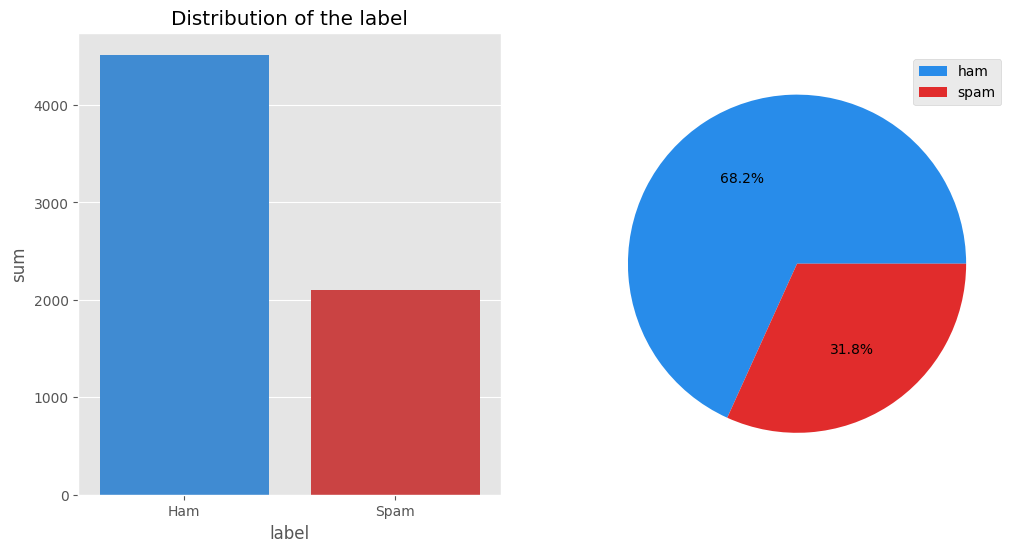

In [22]:
st = data.groupby('label')['label'].value_counts().reset_index(name = 'sum')

fig, ax = plt.subplots(1, 2, figsize = (12, 6))
sns.barplot(data = st, x = 'label', y = 'sum', ax = ax[0], palette=[color_codes["blue"], color_codes["red"]])
ax[0].set_xticklabels(['Ham', 'Spam'])
ax[1].pie(st['sum'], autopct = '%0.1f%%', colors=[color_codes["blue"], color_codes["red"]])
plt.legend(labels = st['label'])
ax[0].set_title('Distribution of the label')
plt.show()

In [23]:
def has_tags(text): # Check if their exist tags in the data
    pattern = re.compile(r'<.*?>')
    match = re.search(pattern, text)
    return match is not None

def count_stop(text): # Count of stopwords
    stops = set(stopwords.words('english'))
    count = sum(1 for word in text if word in stops)
    return count

In [24]:
data['stop_count'] = data['text'].apply(count_stop)
data.head()

,label,text,stop_count
0,ham,"Go until jurong point, crazy.. Available only ...",32
1,ham,Ok lar... Joking wif u oni...,6
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,43
3,ham,U dun say so early hor... U c already then say...,17
4,ham,"Nah I don't think he goes to usf, he lives aro...",18


In [25]:
temp = data.groupby('label')['stop_count'].sum().reset_index(name = 'sum')
temp

,label,sum
0,ham,106874
1,spam,635746


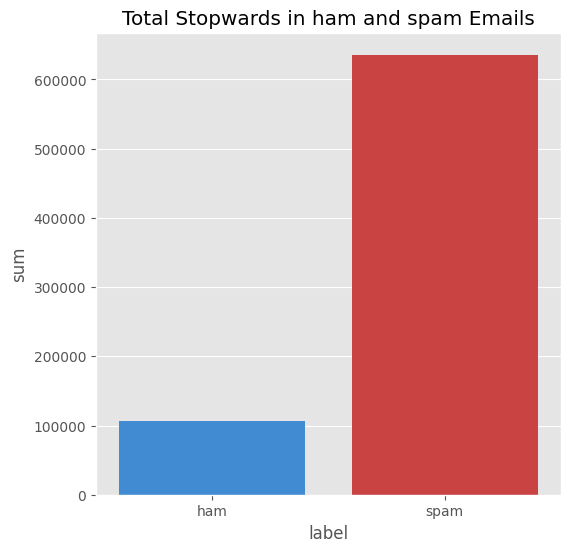

In [26]:
fig = plt.figure(figsize = (6, 6))
sns.barplot(data = temp, x = 'label', y = 'sum', palette=[color_codes["blue"], color_codes["red"]])
plt.title("Total Stopwards in ham and spam Emails")
plt.show()
data.drop(columns=['stop_count'], inplace=True)

In [27]:
data['text'].apply(has_tags).sum()

6

<div style="text-align: center; background:  #ccc5b9; font-family: 'Trebuchet MS', Arial, sans-serif; color: white; padding: 15px; font-size: 26px; font-weight: bold; line-height: 1; border-radius: 50% 0 50% 0 / 40px; margin-bottom: 20px; box-shadow: 0px 4px 6px rgba(0, 0, 0, 0.1); color: #000000">Message preprocessing</div>


In [28]:
def augmentation(text): # augment data to increase the spam emails
    new_text = aug.augment(text)
    return new_text
    
def tokenize(text): # tokenize text into words
    ans = word_tokenize(text)
    return ans

def remove_punc(text): # remove punctuations from the text
    ans = [word for word in text if word not in punctuation]
    return ans

def remove_dots(text): # remove dots from the text
    pattern=re.compile(r'\.*')
    return pattern.sub('', text)

def remove_stop(text): # remove stopwords from the text
    stops = set(stopwords.words('english'))
    ans = " ".join([word for word in text.split() if word not in stops])
    return ans

def stemmer(text): # apply stemming on text
    ans = [ps.stem(word) for word in text]
    return ans

def lemmatizer(text): # apply lemmatization on text
    ans = [lemm.lemmatize(word) for word in text]
    return ans

def remove_links(text): # remove links from the text
    return re.sub(r'https?:\/\/(.[\r\n])', '', text, flags=re.MULTILINE)

def remove_tags(text): # remove html tags
    pattern = re.compile(r'<.*?>')     
    return pattern.sub('', text)

def again(text): # reverse tokenization
    ans = " ".join([word for word in text])
    return ans

def get_length(text): # return the length of the text
    return len(text) - text.count(' ')

def word_count(text): # return count of words in the text
    return len(text.split())

def count_punc(text): # return count of characters in the text
    count = sum([1 for char in text if char in punctuation])
    return round( count/(len(text) - text.count(" ")),3)*100

def count_cap(text): # return count of uppercase characters
    count = sum([1 for char in text if char.isupper()])
    return round( count/(len(text) - text.count(" ")),3)*100

In [29]:
spam_emails = data[data['label'] == 'spam']
spam_emails.head()

,label,text
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
5,spam,FreeMsg Hey there darling it's been 3 week's n...
8,spam,WINNER!! As a valued network customer you have...
9,spam,Had your mobile 11 months or more? U R entitle...
11,spam,"SIX chances to win CASH! From 100 to 20,000 po..."


<span style='font-size:15px; font-family:Verdana;color: #ccc5b9;'><b>Using Augmentation to Add some <b style="color: #E12C2C">Spam</b> Emails</b></span>

In [30]:
for i in spam_emails['text']:
    new_text = aug.augment(i)[0]
    new_record = {
    'label' : 'spam',
    'text' : new_text
    }
    new_df = pd.DataFrame([new_record])
    data = pd.concat([data, new_df], ignore_index=True)

In [31]:
data['label'].value_counts()

label
ham     4516
spam    4206
Name: count, dtype: int64

In [32]:
data = data.sample(frac=1).reset_index(drop = True)
data.head()

,label,text
0,spam,Subject: nathaniel energy (otcbb: necx) strap ...
1,ham,You are always putting your business out there...
2,ham,Haha mayb u're rite... U know me well. Da feel...
3,ham,"Fuck babe, I miss you sooooo much !! I wish yo..."
4,ham,"Painful words- ""I thought being Happy was the ..."


<span style='font-size:15px; font-family:Verdana;color: #ccc5b9;'><b>lower casing all texts</b></span>

In [33]:
data['cleaned'] = data['text'].str.lower()
data.head()

,label,text,cleaned
0,spam,Subject: nathaniel energy (otcbb: necx) strap ...,subject: nathaniel energy (otcbb: necx) strap ...
1,ham,You are always putting your business out there...,you are always putting your business out there...
2,ham,Haha mayb u're rite... U know me well. Da feel...,haha mayb u're rite... u know me well. da feel...
3,ham,"Fuck babe, I miss you sooooo much !! I wish yo...","fuck babe, i miss you sooooo much !! i wish yo..."
4,ham,"Painful words- ""I thought being Happy was the ...","painful words- ""i thought being happy was the ..."


<span style='font-size:15px; font-family:Verdana;color: #ccc5b9;'><b>removing links</b></span>

In [34]:
data['cleaned'] = data['cleaned'].apply(lambda x: remove_links(x))
data['cleaned'].head()

0    subject: nathaniel energy (otcbb: necx) strap ...
1    you are always putting your business out there...
2    haha mayb u're rite... u know me well. da feel...
3    fuck babe, i miss you sooooo much !! i wish yo...
4    painful words- "i thought being happy was the ...
Name: cleaned, dtype: object

<span style='font-size:15px; font-family:Verdana;color: #ccc5b9;'><b>removing tags</b></span>

In [35]:
data['cleaned'] = data['cleaned'].apply(lambda x: remove_tags(x))
data['cleaned'].head()

0    subject: nathaniel energy (otcbb: necx) strap ...
1    you are always putting your business out there...
2    haha mayb u're rite... u know me well. da feel...
3    fuck babe, i miss you sooooo much !! i wish yo...
4    painful words- "i thought being happy was the ...
Name: cleaned, dtype: object

<span style='font-size:15px; font-family:Verdana;color: #ccc5b9;'><b>removing stopwords</b></span>

In [36]:
data['cleaned'] = data['cleaned'].apply(lambda x: remove_stop(x))
data['cleaned'].head()

0    subject: nathaniel energy (otcbb: necx) strap ...
1    always putting business there. put pictures as...
2    haha mayb u're rite... u know well. da feeling...
3    fuck babe, miss sooooo much !! wish sleep ... ...
4    painful words- "i thought happy toughest thing...
Name: cleaned, dtype: object

<span style='font-size:15px; font-family:Verdana;color: #ccc5b9;'><b>applying tokenization</b></span>

In [37]:
data['cleaned'] = data['cleaned'].apply(lambda x: tokenize(x))
data['cleaned'].head()

0    [subject, :, nathaniel, energy, (, otcbb, :, n...
1    [always, putting, business, there, ., put, pic...
2    [haha, mayb, u, 're, rite, ..., u, know, well,...
3    [fuck, babe, ,, miss, sooooo, much, !, !, wish...
4    [painful, words-, ``, i, thought, happy, tough...
Name: cleaned, dtype: object

<span style='font-size:15px; font-family:Verdana;color: #ccc5b9;'><b>removing punctuation</b></span>

In [38]:
data['cleaned'] = data['cleaned'].apply(lambda x: remove_punc(x))
data['cleaned']

0       [subject, nathaniel, energy, otcbb, necx, stra...
1       [always, putting, business, there, put, pictur...
2       [haha, mayb, u, 're, rite, ..., u, know, well,...
3       [fuck, babe, miss, sooooo, much, wish, sleep, ...
4       [painful, words-, ``, i, thought, happy, tough...
                              ...                        
8717    [dont, think, need, yellow, card, uk, travel, ...
8718    [subject, found, something, finally, always, w...
8719    [subject, vicodin, via, gra, che, ap, adam, to...
8720              [dont, let, studying, stress, out, l8r]
8721                 [change, windows, logoff, sound, ..]
Name: cleaned, Length: 8722, dtype: object

<span style='font-size:15px; font-family:Verdana;color: #ccc5b9;'><b>applying lemmatization</b></span>

In [39]:
data['cleaned'] = data['cleaned'].apply(lambda x: lemmatizer(x))
data['cleaned'].head()

0    [subject, nathaniel, energy, otcbb, necx, stra...
1    [always, putting, business, there, put, pictur...
2    [haha, mayb, u, 're, rite, ..., u, know, well,...
3    [fuck, babe, miss, sooooo, much, wish, sleep, ...
4    [painful, words-, ``, i, thought, happy, tough...
Name: cleaned, dtype: object

<span style='font-size:15px; font-family:Verdana;color: #ccc5b9;'><b>applying stemming</b></span>

In [40]:
data['cleaned'] = data['cleaned'].apply(lambda x: stemmer(x))
data['cleaned'].head()

0    [subject, nathaniel, energi, otcbb, necx, stra...
1    [alway, put, busi, there, put, pictur, as, fac...
2    [haha, mayb, u, 're, rite, ..., u, know, well,...
3    [fuck, babe, miss, sooooo, much, wish, sleep, ...
4    [pain, words-, ``, i, thought, happi, toughest...
Name: cleaned, dtype: object

<span style='font-size:15px; font-family:Verdana;color: #ccc5b9;'><b>reverse tokenization</b></span>

In [41]:
data['cleaned'] = data['cleaned'].apply(lambda x: again(x))
data['cleaned'].head()

0    subject nathaniel energi otcbb necx strap port...
1    alway put busi there put pictur as facebook on...
2    haha mayb u 're rite ... u know well da feel l...
3    fuck babe miss sooooo much wish sleep ... bed ...
4    pain words- `` i thought happi toughest thing ...
Name: cleaned, dtype: object

<span style='font-size:15px; font-family:Verdana;color: #ccc5b9;'><b>removing dots</b></span>

In [42]:
data['cleaned'] = data['cleaned'].apply(lambda x: remove_dots(x))
data['cleaned'].head()

0    subject nathaniel energi otcbb necx strap port...
1    alway put busi there put pictur as facebook on...
2    haha mayb u 're rite  u know well da feel like...
3    fuck babe miss sooooo much wish sleep  bed lon...
4    pain words- `` i thought happi toughest thing ...
Name: cleaned, dtype: object

<span style='font-size:15px; font-family:Verdana;color: #ccc5b9;'><b>lengths of each text</b></span>

In [43]:
data['length'] = data['text'].apply(lambda x: get_length(x))
data.head()

,label,text,cleaned,length
0,spam,Subject: nathaniel energy (otcbb: necx) strap ...,subject nathaniel energi otcbb necx strap port...,5691
1,ham,You are always putting your business out there...,alway put busi there put pictur as facebook on...,179
2,ham,Haha mayb u're rite... U know me well. Da feel...,haha mayb u 're rite u know well da feel like...,119
3,ham,"Fuck babe, I miss you sooooo much !! I wish yo...",fuck babe miss sooooo much wish sleep bed lon...,118
4,ham,"Painful words- ""I thought being Happy was the ...",pain words- `` i thought happi toughest thing ...,121


<span style='font-size:15px; font-family:Verdana;color: #ccc5b9;'><b>count of words in each text</b></span>

In [44]:
data['No. words'] = data['text'].apply(lambda x: word_count(x))
data.head()

,label,text,cleaned,length,No. words
0,spam,Subject: nathaniel energy (otcbb: necx) strap ...,subject nathaniel energi otcbb necx strap port...,5691,1134
1,ham,You are always putting your business out there...,alway put busi there put pictur as facebook on...,179,43
2,ham,Haha mayb u're rite... U know me well. Da feel...,haha mayb u 're rite u know well da feel like...,119,31
3,ham,"Fuck babe, I miss you sooooo much !! I wish yo...",fuck babe miss sooooo much wish sleep bed lon...,118,37
4,ham,"Painful words- ""I thought being Happy was the ...",pain words- `` i thought happi toughest thing ...,121,24


<span style='font-size:15px; font-family:Verdana;color: #ccc5b9;'><b>percentage of upper case letters</b></span>

In [45]:
data['cap%'] = data['text'].apply(lambda x: count_cap(x))
data.head()

,label,text,cleaned,length,No. words,cap%
0,spam,Subject: nathaniel energy (otcbb: necx) strap ...,subject nathaniel energi otcbb necx strap port...,5691,1134,0.0
1,ham,You are always putting your business out there...,alway put busi there put pictur as facebook on...,179,43,2.2
2,ham,Haha mayb u're rite... U know me well. Da feel...,haha mayb u 're rite u know well da feel like...,119,31,3.4
3,ham,"Fuck babe, I miss you sooooo much !! I wish yo...",fuck babe miss sooooo much wish sleep bed lon...,118,37,5.1
4,ham,"Painful words- ""I thought being Happy was the ...",pain words- `` i thought happi toughest thing ...,121,24,5.0


<span style='font-size:15px; font-family:Verdana;color: #ccc5b9;'><b>percentage of punctuations</b></span>

In [46]:
data['punc%'] = data['text'].apply(lambda x: count_punc(x))
data.head()

,label,text,cleaned,length,No. words,cap%,punc%
0,spam,Subject: nathaniel energy (otcbb: necx) strap ...,subject nathaniel energi otcbb necx strap port...,5691,1134,0.0,4.0
1,ham,You are always putting your business out there...,alway put busi there put pictur as facebook on...,179,43,2.2,3.4
2,ham,Haha mayb u're rite... U know me well. Da feel...,haha mayb u 're rite u know well da feel like...,119,31,3.4,5.9
3,ham,"Fuck babe, I miss you sooooo much !! I wish yo...",fuck babe miss sooooo much wish sleep bed lon...,118,37,5.1,14.4
4,ham,"Painful words- ""I thought being Happy was the ...",pain words- `` i thought happi toughest thing ...,121,24,5.0,7.4


<span style='font-size:15px; font-family:Verdana;color: #ccc5b9;'><b>number of sentences</b></span>

In [47]:
data['No. sentence'] = data['text'].apply(lambda x: len(sent_tokenize(x)))
data.head()

,label,text,cleaned,length,No. words,cap%,punc%,No. sentence
0,spam,Subject: nathaniel energy (otcbb: necx) strap ...,subject nathaniel energi otcbb necx strap port...,5691,1134,0.0,4.0,60
1,ham,You are always putting your business out there...,alway put busi there put pictur as facebook on...,179,43,2.2,3.4,4
2,ham,Haha mayb u're rite... U know me well. Da feel...,haha mayb u 're rite u know well da feel like...,119,31,3.4,5.9,3
3,ham,"Fuck babe, I miss you sooooo much !! I wish yo...",fuck babe miss sooooo much wish sleep bed lon...,118,37,5.1,14.4,4
4,ham,"Painful words- ""I thought being Happy was the ...",pain words- `` i thought happi toughest thing ...,121,24,5.0,7.4,2


<div style="text-align: center; background:  #ccc5b9; font-family: 'Trebuchet MS', Arial, sans-serif; color: white; padding: 15px; font-size: 26px; font-weight: bold; line-height: 1; border-radius: 50% 0 50% 0 / 40px; margin-bottom: 20px; box-shadow: 0px 4px 6px rgba(0, 0, 0, 0.1); color: #000000">Exploratory Data Analysis</div>


<span style='font-size:15px; font-family:Verdana;color: #ccc5b9;'><b>info of the data</b></span>

In [48]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8722 entries, 0 to 8721
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   label         8722 non-null   object 
 1   text          8722 non-null   object 
 2   cleaned       8722 non-null   object 
 3   length        8722 non-null   int64  
 4   No. words     8722 non-null   int64  
 5   cap%          8722 non-null   float64
 6   punc%         8722 non-null   float64
 7   No. sentence  8722 non-null   int64  
dtypes: float64(2), int64(3), object(3)
memory usage: 545.2+ KB


<span style='font-size:15px; font-family:Verdana;color: #ccc5b9;'><b>Summary describtion of the data</b></span>

In [49]:
data.describe()

,length,No. words,cap%,punc%,No. sentence
count,8722.000000,8722.000000,8722.000000,8722.000000,8722.000000
mean,389.223573,86.820225,5.477929,6.518826,6.998051
std,980.550017,215.253157,11.318188,6.140231,23.579450
min,2.000000,1.000000,0.000000,0.000000,1.000000
25%,40.000000,10.000000,0.400000,3.200000,1.000000
50%,101.000000,23.000000,3.200000,5.200000,2.000000
75%,263.750000,59.000000,5.600000,8.100000,5.000000
max,19666.000000,3962.000000,100.000000,100.000000,1255.000000


In [50]:
data['label'].value_counts()

label
ham     4516
spam    4206
Name: count, dtype: int64

<span style='font-size:15px; font-family:Verdana;color: #ccc5b9;'><b>Now the data looks balanced</b></span>

<div style="text-align: center; background:  #ccc5b9; font-family: 'Trebuchet MS', Arial, sans-serif; color: white; padding: 15px; font-size: 26px; font-weight: bold; line-height: 1; border-radius: 50% 0 50% 0 / 40px; margin-bottom: 20px; box-shadow: 0px 4px 6px rgba(0, 0, 0, 0.1); color: #000000">Data Visualization</div>


<span style='font-size:15px; font-family:Verdana;color: #ccc5b9;'><b>Distribution of <b style="color: #288CEA;">Ham</b> vs <b style="color: #E12C2C">Spam</b> counts</b></span>

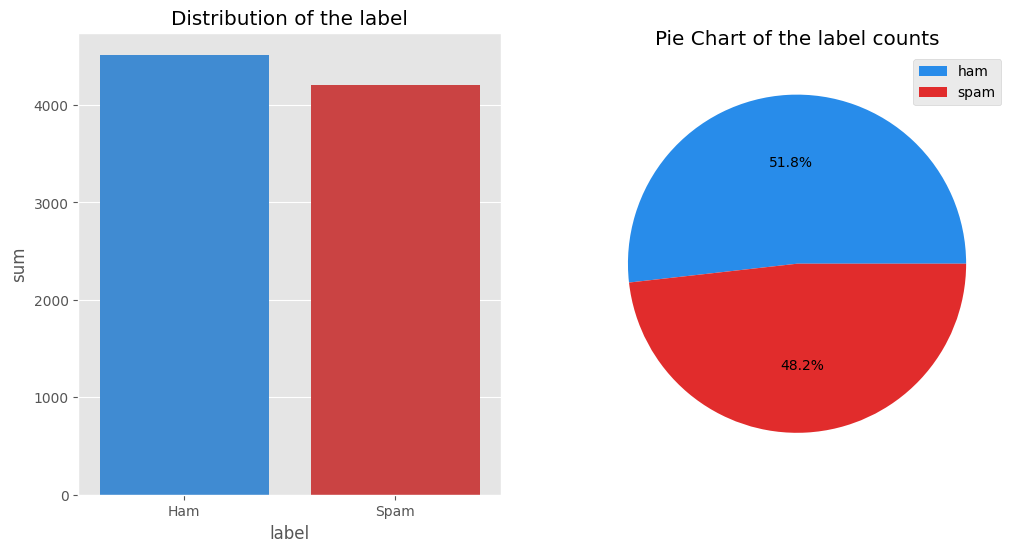

In [51]:
st = data.groupby('label')['label'].value_counts().reset_index(name = 'sum')

fig, ax = plt.subplots(1, 2, figsize = (12, 6))
sns.barplot(data = st, x = 'label', y = 'sum', ax = ax[0], palette=[color_codes["blue"], color_codes["red"]])
ax[0].set_xticklabels(['Ham', 'Spam'])
ax[1].pie(st['sum'], autopct = '%0.1f%%', colors=[color_codes["blue"], color_codes["red"]])
plt.legend(labels = st['label'].value_counts().index)
ax[0].set_title('Distribution of the label')
ax[1].set_title('Pie Chart of the label counts')
plt.show()

<span style='font-size:15px; font-family:Verdana;color: #ccc5b9;'><b>Number of words in <b style="color: #288CEA;">Ham</b> vs <b style="color: #E12C2C">Spam</b></b></span>

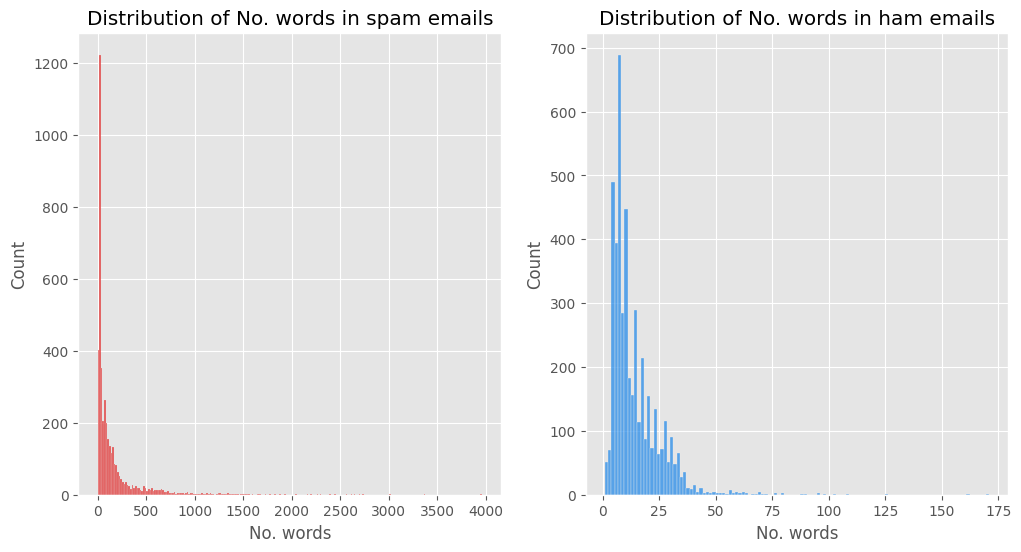

In [52]:
data_spam = pd.DataFrame(data[data["label"] == 'spam']["No. words"])
data_ham = pd.DataFrame(data[data["label"] == 'ham']["No. words"])
fig, ax = plt.subplots(1, 2, figsize = (12, 6))
sns.histplot(data = data_spam, x = 'No. words', ax = ax[0], color = color_codes["red"])
sns.histplot(data = data_ham, x = 'No. words', ax = ax[1], color = color_codes["blue"])
ax[0].set_title('Distribution of No. words in spam emails')
ax[1].set_title('Distribution of No. words in ham emails')
plt.show()

<span style='font-size:15px; font-family:Verdana;color: #ccc5b9;'><b>Lengths of emails in <b style="color: #288CEA;">Ham</b> vs <b style="color: #E12C2C">Spam</b></b></span>

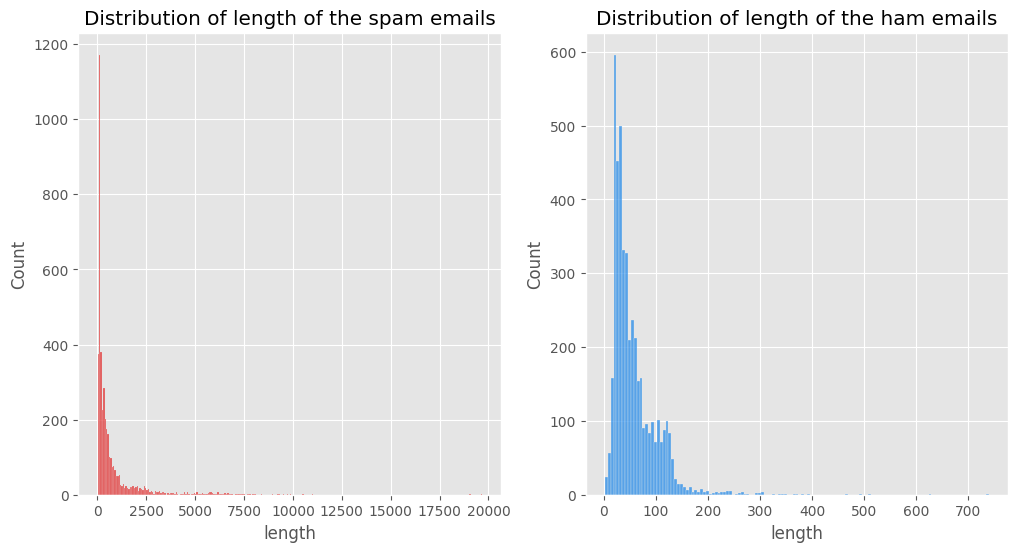

In [53]:
data_spam = pd.DataFrame(data[data["label"] == 'spam']["length"])
data_ham = pd.DataFrame(data[data["label"] == 'ham']["length"])

fig, ax = plt.subplots(1, 2, figsize = (12, 6))
sns.histplot(data = data_spam, x = 'length', ax = ax[0], color = color_codes["red"])
sns.histplot(data = data_ham, x = 'length', ax = ax[1], color = color_codes["blue"])

ax[0].set_title('Distribution of length of the spam emails')
ax[1].set_title('Distribution of length of the ham emails')

plt.show()

<span style='font-size:15px; font-family:Verdana;color: #ccc5b9;'><b>Punctuations in <b style="color: #288CEA;">Ham</b> vs <b style="color: #E12C2C">Spam</b></b></span>

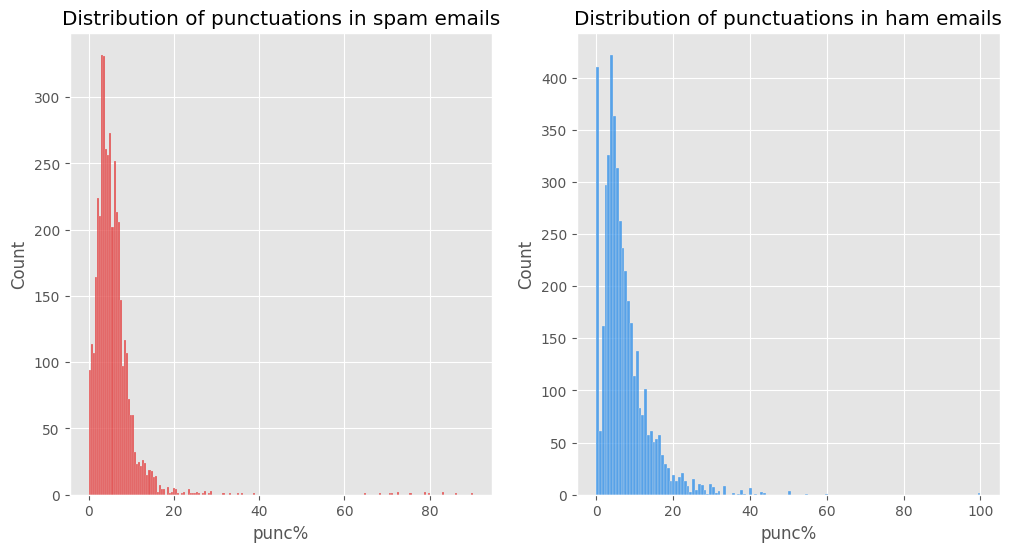

In [54]:
data_spam = pd.DataFrame(data[data["label"] == 'spam']["punc%"])
data_ham = pd.DataFrame(data[data["label"] == 'ham']["punc%"])

fig, ax = plt.subplots(1, 2, figsize = (12, 6))
sns.histplot(data = data_spam, x = 'punc%', ax = ax[0], color = color_codes["red"])
sns.histplot(data = data_ham, x = 'punc%', ax = ax[1], color = color_codes["blue"])

ax[0].set_title('Distribution of punctuations in spam emails')
ax[1].set_title('Distribution of punctuations in ham emails')

plt.show()

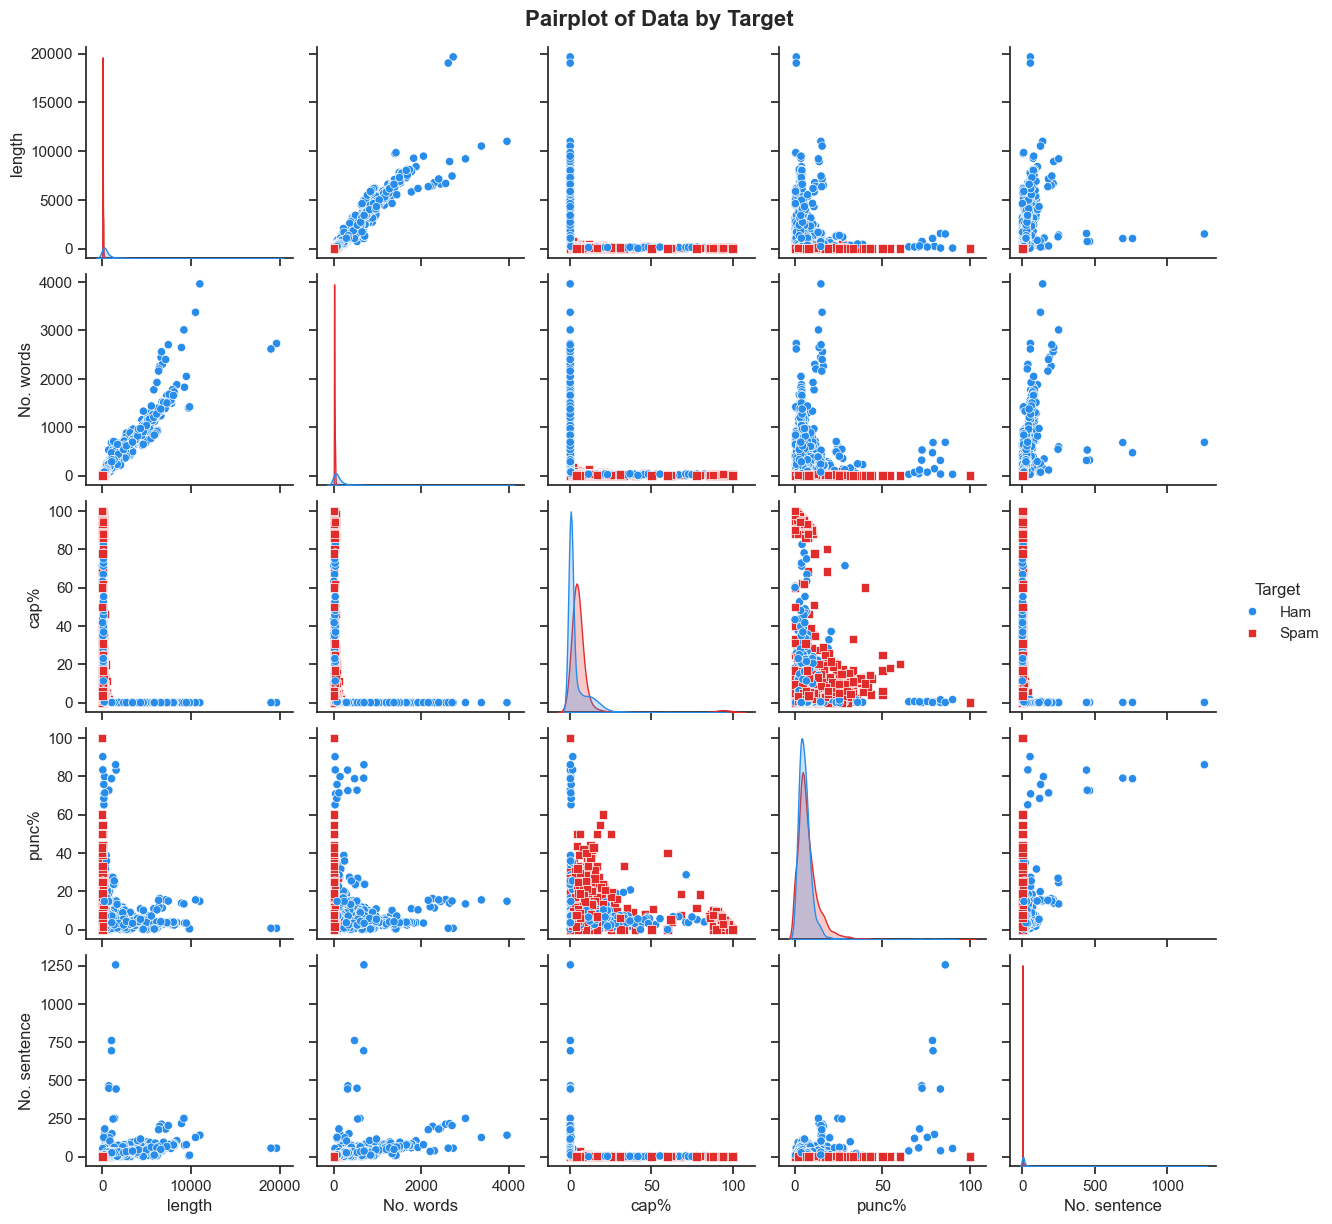

In [55]:
sns.set(style='ticks', color_codes=True)
g = sns.pairplot(data, hue='label', diag_kind='kde', markers=["o", "s"], palette=[color_codes["blue"], color_codes["red"]])

g.fig.suptitle("Pairplot of Data by Target", fontsize=16, fontweight='bold')
plt.subplots_adjust(top=0.95)
g._legend.set_title('Target')
for t, l in zip(g._legend.texts, ["Ham", "Spam"]):
    t.set_text(l)
plt.show()

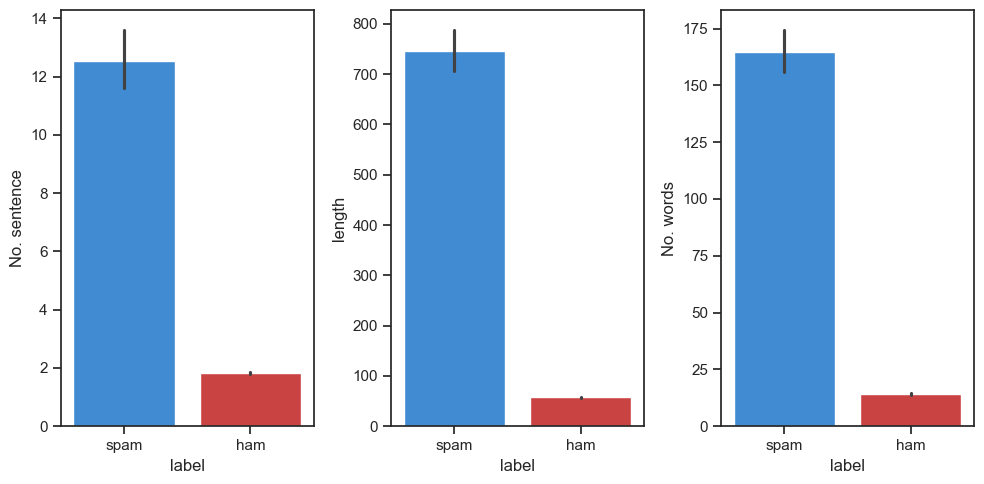

In [56]:
fig, ax = plt.subplots(1, 3, figsize = (10, 5))
sns.barplot(data = data, y = 'No. sentence', x = 'label', ax = ax[0], hue = 'label', palette=[color_codes["blue"], color_codes["red"]])
sns.barplot(data = data, y = 'length', x = 'label', ax = ax[1], hue = 'label', palette=[color_codes["blue"], color_codes["red"]])
sns.barplot(data = data, y = 'No. words', x = 'label', ax = ax[2], hue = 'label', palette=[color_codes["blue"], color_codes["red"]])
plt.tight_layout()
plt.show()

In [57]:
spam_carpos = []
for text in data[data['label'] == 'spam']['cleaned'].tolist():
    for word in text.split():
        spam_carpos.append(word)
filter_df = pd.DataFrame(Counter(spam_carpos).most_common(10))

<span style='font-size:15px; font-family:Verdana;color: #ccc5b9;'><b>Most frequent words in <b style="color: #E12C2C">Spam</b></b></span>

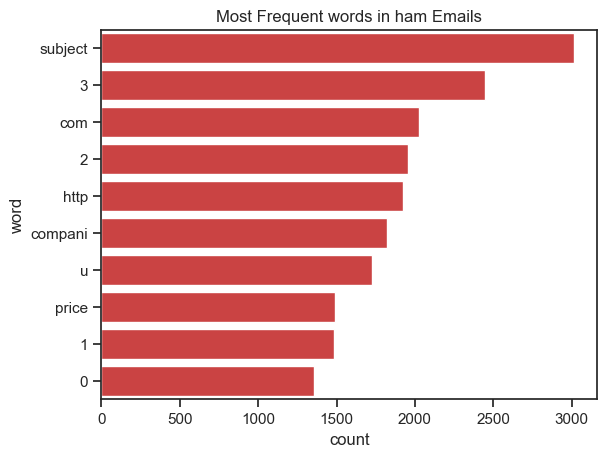

In [58]:
sns.barplot(data = filter_df, y = filter_df[0], x = filter_df[1], color=color_codes["red"])
plt.xlabel('count')
plt.ylabel('word')
plt.title("Most Frequent words in ham Emails")
plt.show()

In [59]:
ham_carpos = []
for text in data[data['label'] == 'ham']['cleaned'].tolist():
    for word in text.split():
        ham_carpos.append(word)
filter_ham_df = pd.DataFrame(Counter(ham_carpos).most_common(10))

<span style='font-size:15px; font-family:Verdana;color: #ccc5b9;'><b>Most frequent words in <b style="color: #288CEA;">Ham</b> </b></span>

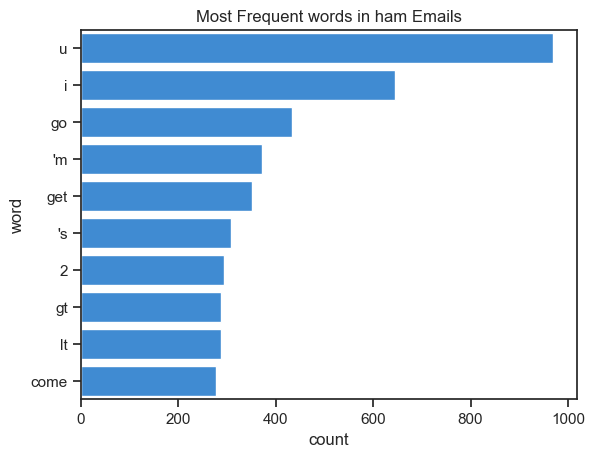

In [60]:
sns.barplot(data = filter_ham_df, y = filter_ham_df[0], x = filter_ham_df[1], color=color_codes["blue"])
plt.xlabel('count')
plt.ylabel('word')
plt.title("Most Frequent words in ham Emails")
plt.show()

<span style='font-size:15px; font-family:Verdana;color: #ccc5b9;'><b>Label Encoding of <b style="color: #288CEA;">Ham</b> to <b style="color: #288CEA;">0</b> and <b style="color: #E12C2C">Spam</b> to <b style="color: #E12C2C">1</b></b></span>

In [61]:
data['label'] = encoder.fit_transform(data['label'])
data.head()

,label,text,cleaned,length,No. words,cap%,punc%,No. sentence
0,1,Subject: nathaniel energy (otcbb: necx) strap ...,subject nathaniel energi otcbb necx strap port...,5691,1134,0.0,4.0,60
1,0,You are always putting your business out there...,alway put busi there put pictur as facebook on...,179,43,2.2,3.4,4
2,0,Haha mayb u're rite... U know me well. Da feel...,haha mayb u 're rite u know well da feel like...,119,31,3.4,5.9,3
3,0,"Fuck babe, I miss you sooooo much !! I wish yo...",fuck babe miss sooooo much wish sleep bed lon...,118,37,5.1,14.4,4
4,0,"Painful words- ""I thought being Happy was the ...",pain words- `` i thought happi toughest thing ...,121,24,5.0,7.4,2


<span style='font-size:15px; font-family:Verdana;color: #ccc5b9;'><b>Correlation Map</b></span>

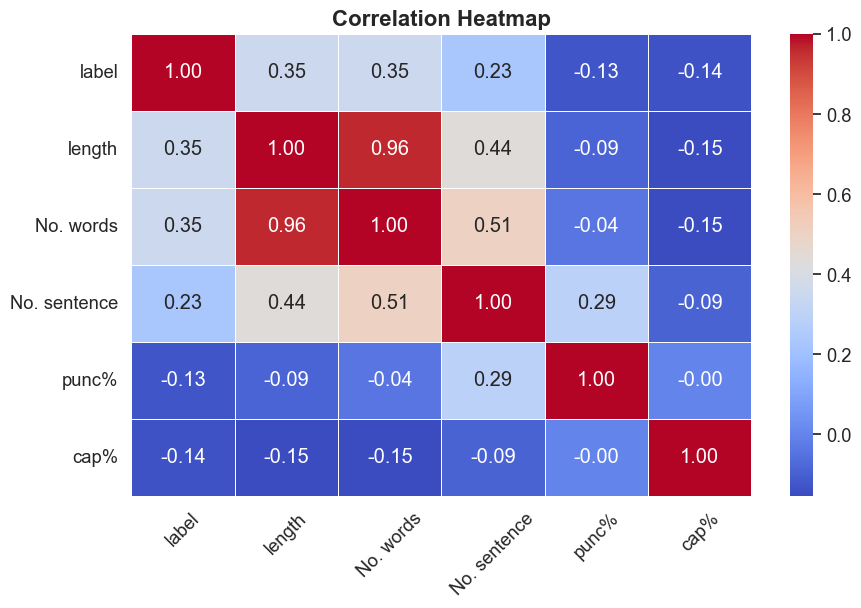

In [62]:
correlation_matrix = data[['label', 'length', 'No. words', 'No. sentence', 'punc%', 'cap%']].corr()

plt.figure(figsize=(10, 6))
sns.set(font_scale=1.2)
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5, fmt=".2f")
plt.title("Correlation Heatmap", fontsize=16, fontweight='bold')
plt.xticks(rotation=45)

plt.show()

<div style="text-align: center; background:  #ccc5b9; font-family: 'Trebuchet MS', Arial, sans-serif; color: white; padding: 15px; font-size: 26px; font-weight: bold; line-height: 1; border-radius: 50% 0 50% 0 / 40px; margin-bottom: 20px; box-shadow: 0px 4px 6px rgba(0, 0, 0, 0.1); color: #000000">Model Building</div>

<span style='font-size:15px; font-family:Verdana;color: #ccc5b9;'><b>Splitting data using <b style="color: #fca311;">SKlrean</b></b></span>

In [63]:
X_train,X_test,y_train,y_test=train_test_split(data['cleaned'],data['label'],test_size=0.30)

In [64]:
# tfidf = TfidfVectorizer()
# features_tfidf = tfidf.fit_transform(X_train)
# print(features_tfidf.shape)
# print('Sparse Matrix :\n', features_tfidf)
# features_tfidf

<span style='font-size:15px; font-family:Verdana;color: #ccc5b9;'><b>Training the model using <b style="color: #fca311;">Random Forest</b></b></span>

In [65]:
RF_model = Pipeline([
    ('tfidf', TfidfVectorizer()),  
    ('rf', RandomForestClassifier())  
])

<span style='font-size:15px; font-family:Verdana;color: #ccc5b9;'><b>Model Fitting</b></span>

In [66]:
RF_model.fit(X_train,y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('rf', RandomForestClassifier())])

<span style='font-size:15px; font-family:Verdana;color: #ccc5b9;'><b>Train Accuracy</b></span>

In [67]:
print("Accuracy of training: {:.3f} %".format(RF_model.score(X_train, y_train) * 100))

Accuracy of training: 100.000 %


<span style='font-size:15px; font-family:Verdana;color: #ccc5b9;'><b>Test Accuracy</b></span>

In [68]:
print("Accuracy of testing: {:.3f} %".format(RF_model.score(X_test, y_test) * 100))

Accuracy of testing: 97.937 %


In [69]:
y_test_prediction = RF_model.predict(X_test)
y_test_prediction[:5]

array([1, 0, 1, 0, 1])

<span style='font-size:15px; font-family:Verdana;color: #ccc5b9;'><b>Precision Score</b></span>

In [70]:
print("Precision Score: {:.3f} %".format(precision_score(y_test, y_test_prediction, pos_label = 1) * 100))

Precision Score: 99.837 %


<span style='font-size:15px; font-family:Verdana;color: #ccc5b9;'><b>score in each fold</b></span>

In [71]:
k_fold = KFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(RF_model, data['cleaned'],data['label'], cv=k_fold)

for i in range(len(scores)):
    print("fold {}: {:.3f} %".format(i+1, scores[i]*100))

fold 1: 98.223 %
fold 2: 98.453 %
fold 3: 97.993 %
fold 4: 98.739 %
fold 5: 98.050 %


<span style='font-size:15px; font-family:Verdana;color: #ccc5b9;'><b>Confusion Matrix</b></span>

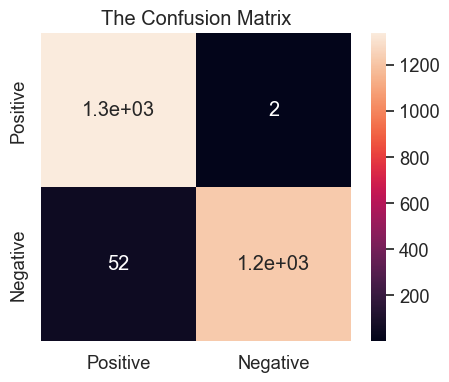

In [72]:
plt.figure(figsize=(5, 4))
cm = confusion_matrix(y_test, y_test_prediction)
sns.heatmap(cm, annot=True)

plt.xticks([0.5, 1.5], ["Positive", "Negative"])
plt.yticks([0.5, 1.5], ["Positive", "Negative"])
plt.title("The Confusion Matrix")
plt.show()


<div style="text-align: center; background:  #ccc5b9; font-family: 'Trebuchet MS', Arial, sans-serif; color: white; padding: 15px; font-size: 26px; font-weight: bold; line-height: 1; border-radius: 50% 0 50% 0 / 40px; margin-bottom: 20px; box-shadow: 0px 4px 6px rgba(0, 0, 0, 0.1); color: #000000">Preserving The Model</div>

In [73]:
import pickle

filename = '../Models/model.sav'
pickle.dump(RF_model, open(filename, 'wb'))